In [54]:
import pandas as pd

performance_data = pd.read_csv('performance_data.csv')
submission_template = pd.read_csv('submission_template.csv')
weather_data = pd.read_csv('weather_data.csv')

In [55]:
performance_data.head()

,HYBRID_ID,ENV_ID,HYBRID_MG,ENV_MG,YIELD,YEAR,LAT,LONG,PLANT_DATE,HARVEST_DATE,...,ENV_YIELD_STD,ELEVATION,CLAY,SILT,SAND,AWC,PH,OM,CEC,KSAT
0,H2782,Env_1,0,0,107.9577,2008,49.5,-98.0,2008-05-06,2008-11-03,...,7.591866,870.65,22.7,23.0,54.5,18.65,7.2,6.1,24.2,9.4
1,H2782,Env_2,0,0,85.7498,2008,49.3,-98.1,2008-05-14,2008-10-22,...,7.184953,942.41,22.7,22.0,55.8,18.75,7.3,6.9,25.2,10.2
2,H2240,Env_3,0,0,74.6116,2011,49.3,-98.0,2011-05-17,2011-10-17,...,4.583234,903.46,22.8,21.5,55.8,18.95,7.4,6.7,25.5,9.9
3,H1527,Env_3,0,0,83.8191,2011,49.3,-98.0,2011-05-17,2011-10-17,...,4.583234,903.46,22.8,21.5,55.8,18.95,7.4,6.7,25.5,9.9
4,H1369,Env_3,0,0,81.7917,2011,49.3,-98.0,2011-05-17,2011-10-17,...,4.583234,903.46,22.8,21.5,55.8,18.95,7.4,6.7,25.5,9.9


In [56]:
performance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387427 entries, 0 to 387426
Data columns (total 22 columns):
HYBRID_ID         387427 non-null object
ENV_ID            387427 non-null object
HYBRID_MG         387427 non-null int64
ENV_MG            387427 non-null int64
YIELD             387427 non-null float64
YEAR              387427 non-null int64
LAT               387427 non-null float64
LONG              387427 non-null float64
PLANT_DATE        387427 non-null object
HARVEST_DATE      387427 non-null object
IRRIGATION        379143 non-null object
ENV_YIELD_MEAN    387427 non-null float64
ENV_YIELD_STD     387427 non-null float64
ELEVATION         387427 non-null float64
CLAY              387427 non-null float64
SILT              387427 non-null float64
SAND              387427 non-null float64
AWC               387427 non-null float64
PH                387427 non-null float64
OM                387427 non-null float64
CEC               387427 non-null float64
KSAT              

In [57]:
performance_data.describe()

,HYBRID_MG,ENV_MG,YIELD,YEAR,LAT,LONG,ENV_YIELD_MEAN,ENV_YIELD_STD,ELEVATION,CLAY,SILT,SAND,AWC,PH,OM,CEC,KSAT
count,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000
mean,5.132190,5.480511,120.738228,2012.781236,41.661369,-91.262012,120.291649,13.378154,1159.748470,24.429210,48.748303,26.796305,23.715754,6.397536,5.556450,25.454481,2.367292
std,1.707665,1.800359,21.995931,2.602693,2.360795,5.839294,17.447066,2.975853,702.488253,4.136108,10.626200,12.379756,2.083614,0.375251,2.223076,3.704428,1.672286
min,0.000000,0.000000,6.031800,2008.000000,26.100000,-104.900000,28.077529,2.807647,-2.500000,6.800000,9.300000,0.000000,11.400000,4.700000,1.600000,8.033333,0.500000
25%,4.000000,4.000000,107.817400,2011.000000,40.300000,-95.200000,109.749895,11.588648,754.390000,21.800000,40.500000,17.200000,22.500000,6.200000,4.000000,23.200000,1.200000
50%,5.000000,6.000000,122.128700,2013.000000,41.500000,-91.900000,121.749200,12.949489,1004.810000,24.700000,48.300000,27.000000,24.000000,6.300000,5.000000,25.700000,1.800000
75%,7.000000,7.000000,135.356250,2015.000000,43.300000,-87.600000,131.434895,15.037107,1278.860000,27.200000,57.500000,35.700000,25.350000,6.600000,6.900000,27.700000,3.100000
max,8.000000,9.000000,230.607000,2017.000000,49.500000,-71.500000,181.664953,41.182394,4905.310000,39.500000,72.800000,83.300000,28.250000,7.900000,20.300000,43.200000,14.700000


In [58]:
joined_df.head()


,HYBRID_ID,ENV_ID,HYBRID_MG,ENV_MG,YIELD,YEAR,LAT,LONG,PLANT_DATE,HARVEST_DATE,...,OM,CEC,KSAT,DAYL,PREC,SRAD,SWE,TMAX,TMIN,VP
0,H2782,Env_1,0,0,107.9577,2008,49.5,-98.0,2008-05-06,2008-11-03,...,6.1,24.2,9.4,43200.000043,1.684932,276.111781,11.167123,8.093151,-3.256164,630.356164
1,H2782,Env_2,0,0,85.7498,2008,49.3,-98.1,2008-05-14,2008-10-22,...,6.9,25.2,10.2,43200.000054,1.621918,278.706849,9.545205,8.178082,-3.290411,612.602740
2,H2240,Env_3,0,0,74.6116,2011,49.3,-98.0,2011-05-17,2011-10-17,...,6.7,25.5,9.9,43200.000054,1.183562,274.112876,4.394521,9.805479,-1.224658,717.917808
3,H1527,Env_3,0,0,83.8191,2011,49.3,-98.0,2011-05-17,2011-10-17,...,6.7,25.5,9.9,43200.000054,1.183562,274.112876,4.394521,9.805479,-1.224658,717.917808
4,H1369,Env_3,0,0,81.7917,2011,49.3,-98.0,2011-05-17,2011-10-17,...,6.7,25.5,9.9,43200.000054,1.183562,274.112876,4.394521,9.805479,-1.224658,717.917808


## Geojson map based on the coordenates of performance_data

In [47]:
# Import modules
#joined_df
import geojsonio
import json

# Get data for map
map_data = performance_data.groupby(by=['LONG','LAT']).size()
map_df = pd.DataFrame(map_data)
map_df = map_df.reset_index()
map_df.columns = ['LONG','LAT','COUNT']


# Build geojson dictionary    
map_geojson = { "type" : "FeatureCollection",
           "features": []}
for i in range(len(map_df)):
    dict_iter = {'type':'Feature',
                'geometry':{'type':'Point','coordinates':[map_df.iloc[i]['LONG'],map_df.iloc[i]['LAT']]},
                'properties':{'crop count':map_df.iloc[i]['COUNT']}}
    map_geojson['features'].append(dict_iter)

    
# Set up a map
#geojsonio.display(json.dumps(map_geojson))
map_df.head()
# Additionally, we could do a heatmap on the conditions

,LONG,LAT,COUNT
0,-104.9,40.3,618
1,-104.8,40.4,375
2,-104.7,40.3,214
3,-103.4,41.8,319
4,-103.0,36.1,404


In [144]:
factor_df = joined_df[['LONG', 'LAT', 'PREC', 'TMAX', 'TMIN']].drop_duplicates()
#determine min, mean, max
#segment factor from 1 to 4

def factor_seg(df, factor):
    min_ = factor_df[factor].min()
    max_ = factor_df[factor].max()
    mean_ = factor_df[factor].mean()
    #binning
    diff = (max_ - min_)/4
    b_l = list()
    for x in range(len(df)):
        temp = 0
        if df.iloc[x][factor] < (min_ + diff):
            temp = 1
        elif df.iloc[x][factor] < (min_ + 2*diff):
            temp = 2
        elif df.iloc[x][factor] < (min_ + 3*diff):
            temp = 3
        else:
            temp = 4
        b_l.append(temp)
    df.insert(loc=0, column=factor + '_binning', value=b_l)
    return df
test_df = factor_seg(factor_df, 'PREC')
#test_df
#test_df.loc[:, 'PREC_binning']

In [100]:
#folium map
import folium
m = folium.Map(location=[39, -96], zoom_start=4, tiles='Stamen Terrain')
prec_data = joined_json #pd.DataFrame(joined_json)
#prec_data.reset_index()
for x in range(len(prec_data)):
    folium.Marker([prec_data.iloc[x]['LAT'], prec_data.iloc[x]['LONG']], popup=str(prec_data.iloc[x]['PREC'])).add_to(m)

prec_data.describe()

,LONG,LAT,PREC
count,1518.000000,1518.000000,1518.000000
mean,-90.621805,41.199473,2.589729
std,7.335024,3.555344,0.775858
min,-104.900000,26.100000,0.512329
25%,-96.575000,39.900000,2.054110
50%,-91.600000,41.400000,2.586301
75%,-85.300000,43.600000,3.052055
max,-71.500000,49.500000,6.098630


In [98]:
#prec buckets
min = prec_data

In [ ]:
import branca


colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 50e3)
#employed_series = df.set_index('FIPS_Code')['Employed_2011']
joined_json = joined_df[['LONG', 'LAT', 'PREC']].drop_duplicates()
prec_data = joined_json
prec_data.reset_index()

def style_function(feature):
    employed = employed_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if employed is None else colorscale(employed)
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

folium.TopoJson(
    open(county_geo),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)


m
Out[15]:


In [49]:
#401 requires authentication: Authentication Failed
#Precipitation 
joined_json = joined_df[['LONG', 'LAT', 'PREC']].drop_duplicates()
prec_data = pd.DataFrame(joined_json)
prec_data.reset_index()
prec_data.columns = ['LONG', 'LAT', 'PREC']
map_geojson_2 = { "type" : "FeatureCollection",
           "features": []}
print(len(prec_data))
for i in range(len(prec_data)):
    dict_iter_2 = {'type':'Feature',
                    'geometry':{'type':'Point','coordinates':[prec_data.iloc[i]['LONG'],prec_data.iloc[i]['LAT']]},
                    'properties':{'prec':prec_data.iloc[i]['PREC']}}
    map_geojson_2['features'].append(dict_iter_2)

geojsonio.display(json.dumps(map_geojson_2))

1518


AuthenticationFailed: 401 Requires authentication

## Correlation heatmap
There are no strong correlations between weather conditions and yield if we look at the aggregated data. We can conclude we'll have to go one level deeper and do the analysis on every specific Hybrid_ID

HYBRID_MG    0.219539
YEAR         0.208669
ENV_MG       0.162916
SRAD         0.161162
ELEVATION    0.154716
Name: YIELD, dtype: float64 OM     -0.163030
LONG   -0.141509
SWE    -0.115704
LAT    -0.103775
SAND   -0.073778
Name: YIELD, dtype: float64


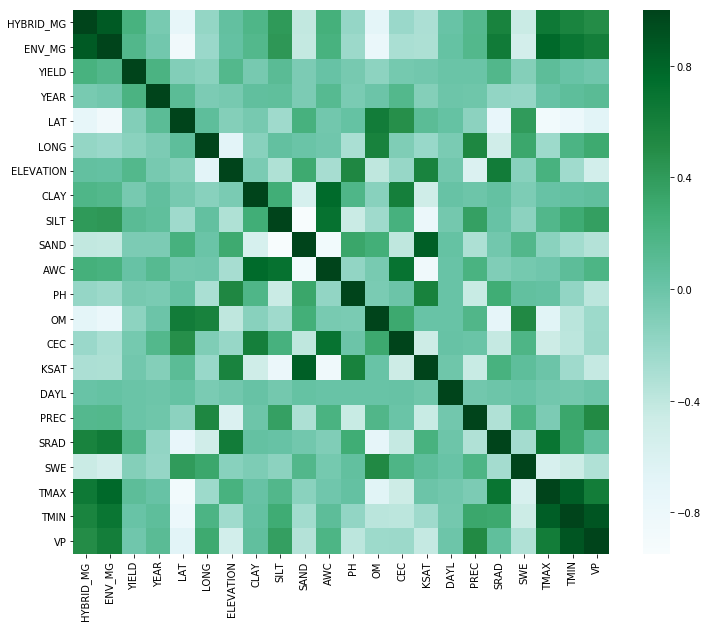

In [42]:
# Import modules
import seaborn as sns
import numpy as np

# Extract average weather metrics for every ENV_ID
weather_grouped = weather_data.groupby(by='ENV_ID').mean()
weather_grouped = weather_grouped.drop('DAY_NUM', axis='columns')

# Join dataframes on 'ENV_ID'
joined_df = performance_data.join(weather_grouped,on='ENV_ID')

# Prepare dataframe to redo correlation matrix
joined_df_drop = joined_df.drop(['HYBRID_ID','ENV_ID','ENV_YIELD_MEAN','ENV_YIELD_STD'],axis='columns')
corr_matrix_joined = joined_df_drop.corr()

# Draw heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_joined,cmap='BuGn')
top_5 = corr_matrix_joined['YIELD'].sort_values(ascending=False).iloc[1:6]
bottom_5 = corr_matrix_joined['YIELD'].sort_values(ascending=True).iloc[0:5]
print(top_5,bottom_5)

#### When looked at an individual level, we see a negative correlation between yield and TMIN, LONG and CLAY

HYBRID_ID
H1117    25624
H1037    22486
H1019    14226
H1010    12903
H1025    10602
dtype: int64
ELEVATION    0.224730
YEAR         0.205393
SRAD         0.187327
KSAT         0.137388
SAND         0.082680
Name: YIELD, dtype: float64 VP     -0.214148
TMIN   -0.210819
LONG   -0.174647
CLAY   -0.152339
AWC    -0.112313
Name: YIELD, dtype: float64


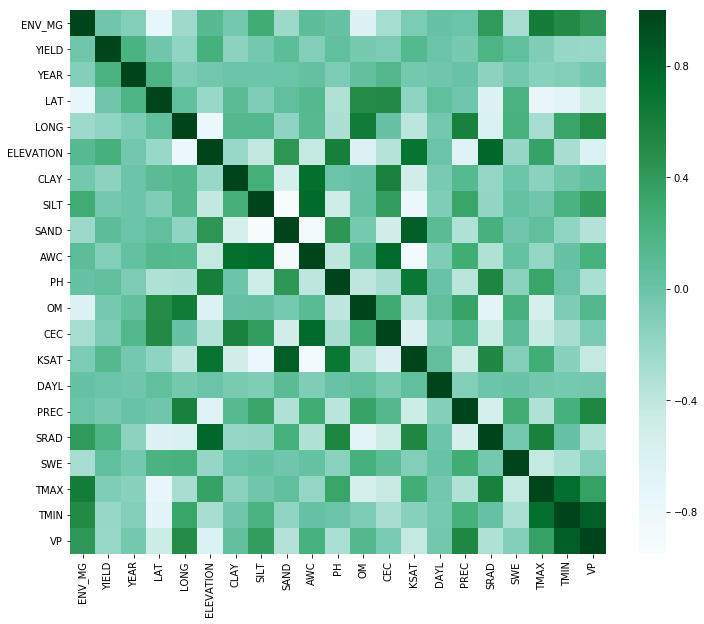

In [6]:
# Repeat the same but just for one HYBRID_ID
# Find out HYBRID_IDs with most observations to draw significant conclusions
print(joined_df.groupby(by='HYBRID_ID').size().sort_values(ascending=False).iloc[:5])

# Choose H1117 hybrid
joined_df_H1117 = joined_df[joined_df['HYBRID_ID']=='H1117']

# Prepare dataframe to redo correlation matrix
joined_df_H1117 = joined_df_H1117.drop(['HYBRID_ID','ENV_ID','HYBRID_MG','ENV_YIELD_MEAN','ENV_YIELD_STD'],axis='columns')
corr_matrix_H1117 = joined_df_H1117.corr()

# Draw heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_H1117,cmap='BuGn')
top_5 = corr_matrix_H1117['YIELD'].sort_values(ascending=False).iloc[1:6]
bottom_5 = corr_matrix_H1117['YIELD'].sort_values(ascending=True).iloc[0:5]
print(top_5,bottom_5)



HYBRID_ID
H1117    25624
H1037    22486
H1019    14226
H1010    12903
H1025    10602
dtype: int64
 
TOP 5:
OM      0.160760
SWE     0.138553
PREC    0.133931
YEAR    0.117511
LAT     0.081385
Name: YIELD, dtype: float64

BOTTOM 5:
TMAX     -0.237768
TMIN     -0.179694
CLAY     -0.142541
ENV_MG   -0.128135
VP       -0.109547
Name: YIELD, dtype: float64


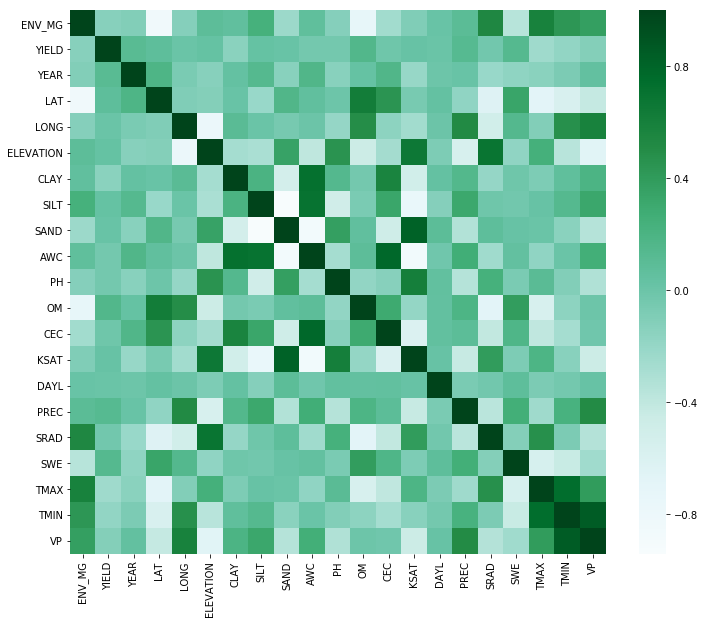

In [7]:
# Repeat the same but just for one HYBRID_ID
# Find out HYBRID_IDs with most observations to draw significant conclusions
print(joined_df.groupby(by='HYBRID_ID').size().sort_values(ascending=False).iloc[:5])

# Choose H1037 hybrid
joined_df_H1037 = joined_df[joined_df['HYBRID_ID']=='H1037']

# Prepare dataframe to redo correlation matrix
joined_df_H1037 = joined_df_H1037.drop(['HYBRID_ID','ENV_ID','HYBRID_MG','ENV_YIELD_MEAN','ENV_YIELD_STD'],axis='columns')
corr_matrix_H1037 = joined_df_H1037.corr()

# Draw heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix_H1037,cmap='BuGn')
top_5 = corr_matrix_H1037['YIELD'].sort_values(ascending=False).iloc[1:6]
bottom_5 = corr_matrix_H1037['YIELD'].sort_values(ascending=True).iloc[0:5]
print(' ')
print('TOP 5:')
print(top_5)
print('')
print('BOTTOM 5:')
print(bottom_5)

In [8]:
performance_data.groupby(by=['HYBRID_ID','ENV_ID']).size()

HYBRID_ID  ENV_ID  
H1000      Env_1018     1
           Env_1034     2
           Env_1042     2
           Env_106      1
           Env_1066     1
           Env_1071     1
           Env_109      1
           Env_112     13
           Env_1230     1
           Env_132      1
           Env_135      1
           Env_1369     2
           Env_1371     2
           Env_1372     2
           Env_154      1
           Env_163      1
           Env_184      1
           Env_189      1
           Env_198     36
           Env_199     12
           Env_200      6
           Env_201      4
           Env_202     31
           Env_206      2
           Env_209     46
           Env_212      1
           Env_213      3
           Env_216     46
           Env_220      1
           Env_221      5
                       ..
H4017      Env_626      1
           Env_752      1
           Env_759      1
           Env_767      1
           Env_772      1
           Env_780      1
           Env_781

In [ ]:
#change joined_df.iloc[:, 10] 'IRRAGATION column into numerical values
#currently: ['DRY', 'NONE', 'IRR', nan, 'LIRR', 'ECO']

In [172]:
#ML model
#performance_data
from sklearn.model_selection import train_test_split
train, test = train_test_split(joined_df, test_size = 0.3)
x_train = train.iloc[:, 11:]
y_train = train['YIELD']
x_test = x_train = test.iloc[:, 11:]
y_test = test['YIELD']

In [173]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [116229, 271198]

In [177]:
#joined_df.iloc[:, 10:]
joined_df.iloc[:, 11:].count()

ENV_YIELD_MEAN    387427
ENV_YIELD_STD     387427
ELEVATION         387427
CLAY              387427
SILT              387427
SAND              387427
AWC               387427
PH                387427
OM                387427
CEC               387427
KSAT              387427
DAYL              387427
PREC              387427
SRAD              387427
SWE               387427
TMAX              387427
TMIN              387427
VP                387427
dtype: int64